In [1]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv
from agrobrain_util.infra.app_config import application_config as cfg
import matplotlib.pyplot as plt


env = RuntimeEnv()
categories_dict = cfg['tags']['categories']

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables


# Create images dataframe

In [2]:
# READ ORDERS CSV FROM JIRA DATA
orders_csv_2022_path = '/mnt/disks/datasets/wide_images/us_2022_emergence_analysis_jira.csv'
orders_df = pd.read_csv(orders_csv_2022_path)
orders_df = orders_df.dropna(subset=['Order ID'])
orders_df['Order ID'] = orders_df['Order ID'].astype(int)
orders_list = list(orders_df['Order ID'])

In [3]:
len(orders_list)

5544

In [3]:
# CREATE SUB DF FOR EXPERIMENTS
orders_df = orders_df.head(20)
orders_list = list(orders_df['Order ID'])

In [4]:
# ADD IMAGES DATA BY ORDER ID FROM ETI

example_images_df = env.eti_api.get_images_data_by_orderid(orders_list[0])['images']
images_df = pd.DataFrame(columns=example_images_df[0].keys())

folder_dir = '/mnt/disks/datasets/wide_images/images_df_folder_1'
os.makedirs(folder_dir, exist_ok=True)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for i, order in enumerate(tqdm(orders_list)):
        order_df = pd.DataFrame(env.eti_api.get_images_data_by_orderid(order)['images'])
        images_df = pd.concat([images_df, order_df], axis='rows', ignore_index=True)
        if len(images_df) > 500:
            images_df.to_csv(f"/mnt/disks/datasets/wide_images/images_df_folder_1/images_df_{i}.csv")
            images_df = pd.DataFrame(columns=example_images_df[0].keys())
    images_df.to_csv(f"/mnt/disks/datasets/wide_images/images_df_folder_1/images_df_{i}.csv")

100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


In [25]:
# CONCAT SMALL DATAFRAMES (SAVED IN .PY?) TO ONE IMAGE_DF AND SAVE TO CSV
folders_path = '/mnt/disks/datasets/wide_images/images_df_folder_1'
csv_list = glob.glob(os.path.join(folders_path, "*.csv"))
im_df = pd.DataFrame()
for csv in tqdm(csv_list):
    df = pd.read_csv(csv)
    im_df = pd.concat([im_df, df], axis='rows', ignore_index=True)
im_df.to_csv('/mnt/disks/datasets/wide_images/images_df.csv')

# Read images dataframe, add features and save

In [4]:
images_df = pd.read_csv('/mnt/disks/datasets/wide_images/images_df.csv')


In [5]:
len(images_df)

568514

In [5]:
images_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'imageID', 'identifier', 'parcelID',
       'snapshotDate', 'timeGps', 'uploadDate', 'fieldID', 'cropID',
       'flightID', 'clientID', 'heightAboveGround', 'quality', 'lat', 'lon',
       'flag', 'healthy', 'expertReview', 'taggerReview', 'taggerDone',
       'autoDone', 'blackList', 'hasTiles', 'format', 'height', 'width',
       'focalLength', 'deleted', 'comment', 'stats', 'stamp', 'plantReport',
       'orderID', 'cameraFileName', 'ignored', 'flightTargetHeight',
       'cameraDegree', 'contrast', 'brightness', 'sharpness', 'typeId',
       'groupUUID', 'cameraModel', 'footprintArea', 'footprintGeography',
       'objectDistance', 'cameraAngle', 'tagsLastVersion', 'imgUrl',
       'fieldName', 'farmID', 'farmName', 'clientName', 'fieldGeojson',
       'cropName'],
      dtype='object')

In [5]:
images_df = images_df.head(20)

In [ ]:
# ADD "NUM WEED TAGS" TO IMAGES_DF AND SAVE
images_df["num_weed_tags"] = None
for i, im_id in tqdm(enumerate(images_df["imageID"])):
    image_stats_list = eval(images_df['stats'][i])
    image_weed_tags_count = 0
    for cat in image_stats_list:
        if cat['category'] == categories_dict['weed']:
            image_weed_tags_count += cat['tagsCount']
    images_df.loc[images_df['imageID'] == im_id, "num_weed_tags"] = image_weed_tags_count
print("saving csv")
images_df.to_csv("/mnt/disks/datasets/wide_images/images_df_new.csv")

# Checkups

In [2]:
full_im_df = pd.read_csv("/mnt/disks/datasets/wide_images/images_df_new.csv")

In [9]:
len(np.unique(orders_list))

5544

In [7]:
# CHECK WHAT ORDERS ARE IN "ORDERS_LIST" AND NOT IN "IMAGE_DF"

print(f"There are {len(np.unique(full_im_df['orderID']))} orders in im_df and {len(orders_list)} orders in orders_list")
orders_list_from_im_df = np.unique(full_im_df['orderID'])
not_in_im_df = set(orders_list) - set(orders_list_from_im_df)
not_in_im_df = list(not_in_im_df)

There are 5541 orders in im_df and 5544 orders in orders_list


In [ ]:
orders_df[orders_df['Too Early'].isna()]

In [20]:
orders_df[orders_df['Order ID'].isin(not_in_im_df)]['# Of Images']

48     85.0
494    28.0
789     0.0
Name: # Of Images, dtype: float64

In [13]:
orders_df[orders_df['Order ID'].isin(not_in_im_df)].columns

Index(['Order ID', 'Country', 'Key', 'Crop', '# Of Images', 'Status',
       'Finish Uploading Time', 'Sensor System', 'Emergence - Accuracy',
       'Emergence - Link To Report', 'Emergence - Model Name',
       'Emergence - Precision', 'Emergence - Recall',
       'Algo - Emergence Labels', 'Resend Reasons', 'Scheduled Flight Date',
       'Summary', '# of images tagged fully automatically (final)',
       '# of images tagged manually (final)',
       '# of images tagged fully automatically', 'QC Tool Link',
       'QC Tool Priority', 'Is QC Tool Operation', 'Labels', 'Customer Type',
       'Ignore AI Filter', '% Auto', '% Auto Cum', 'Analyzed', 'comment',
       'Too Early', 'Date'],
      dtype='object')

# Experiments - delete after

In [ ]:
# GET WEEDS CATEGOTY ID
categories_hierarchy = env.eti_api.get_categories_hierarchy()
for i in range(len(categories_hierarchy)):
    print(f"index {i}, category: {categories_hierarchy[i]['id']}")

# GET LIST OF SUBCATEGORIES IDS
weeds_subcategories_ids = [categories_hierarchy[9]['subCategories'][i]['id'] for i in range(len(categories_hierarchy[9]['subCategories']))]
weeds_subcategories_ids

In [ ]:
categories_hierarchy[9]['subCategories']

In [3]:
images_df = full_im_df

In [30]:
eval(images_df['stats'][6])[0]['category'] == categories_dict['weed']

True

In [25]:
len(eval(images_df['stats'][19]))

1

In [4]:
type(categories_dict['weed'])

int

In [7]:
len(images_df)

568514

In [8]:
images_df = images_df.head(100)

In [6]:
# CREATE COLUMNS: "WEED_TYPES_IDS_LIST", "AREAPERCENTAGE", "INFERENCETAGSCOUNT" AND SAVE IMAGES_DATAFRAME

images_df["weed_types_ids_list"] = None
images_df["weed_areaPercentage"] = None
images_df["weed_inferenceTagsCount"] = None


for i, im_id in enumerate(tqdm(images_df["imageID"])):
    image_stats_list = eval(images_df.loc[i, 'stats'])
    weed_types_ids_list = []
    areaPercentage = []
    inferenceTagsCount = []
    for cat in image_stats_list:
        if cat['category'] == categories_dict['weed']:
            weed_types_ids_list.append(cat['subCategory'])
            areaPercentage.append(cat['areaPercentage'])
            inferenceTagsCount.append(cat['inferenceTagsCount'])
    images_df.loc[i, "weed_types_ids_list"] = str(weed_types_ids_list)
    images_df.loc[i, "weed_areaPercentage"] = str(areaPercentage)
    images_df.loc[i, "weed_inferenceTagsCount"] = str(inferenceTagsCount)

# FILTER DATAFRAME - TAKE ONLY IMAGES THAT HAVE WEEDS (AT LEAST ONE WITH CATEGORY 5)
weeds_images_df = images_df[images_df['weed_types_ids_list'].apply(lambda x: len(eval(x)) > 0)].reset_index(drop=True)
weeds_images_df.to_csv("/mnt/disks/datasets/wide_images/weeds_images_df.csv")
weeds_images_df['weed_types_ids_list'] = weeds_images_df['weed_types_ids_list'].apply(eval)


100%|██████████| 568514/568514 [02:45<00:00, 3438.64it/s]


In [25]:
# READ WEEDS IMAGES DF
weeds_images_df = pd.read_csv("/mnt/disks/datasets/wide_images/weeds_images_df.csv")
weeds_images_df['weed_types_ids_list'] = weeds_images_df['weed_types_ids_list'].apply(eval)

In [50]:
def create_cat_dict(cat_list):
    cat_dict_types = {}
    cat_dict_names = {}
    for l in cat_list:
        cat_dict_types[l['id']] = l['type']
        if 'name' in l:
            cat_dict_names[l['id']] = l['name']
        else:
            cat_dict_names[l['id']] = 'NoName'
    return cat_dict_types, cat_dict_names
cat_dict_types, cat_dict_names = create_cat_dict(categories_hierarchy[9]['subCategories'])

unique_weed_types, count_unique_weed_types = np.unique(weeds_images_df['weed_types_ids_list'].explode(), return_counts=True)
top_weed_types = unique_weed_types[np.argsort(count_unique_weed_types)[-5:]]
top_weed_types_names = [cat_dict_names[id] for id in top_weed_types]
# print(top_weed_types_names)

In [47]:
unique_weed_types

array([0, 141, 156, 158, 166, 186, 188, 194, 211, 212, 215, 224, 252, 260,
       272, 351, 368, 379, 393, 418, 429, 465, 466, 467, 510, 657, 827,
       858, 951, 1695, 1737], dtype=object)

In [42]:
count_unique_weed_types

array([     9,    204,      2, 278760,      1,      2,     26,      2,
         1829, 186816,      1,      1,      1,      2,      1,      7,
            5,      5,      2,      6,     11,      2, 110765,      5,
            1,     16,      1,      2,      1,      1,      8])

In [53]:
unique_weed_types[np.argsort(count_unique_weed_types)[-3:]]

array([466, 212, 158], dtype=object)

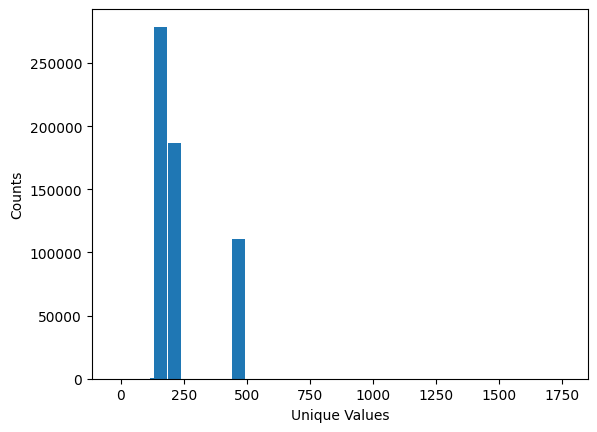

In [41]:
bar_width = 50
plt.bar(unique_weed_types, count_unique_weed_types, width=bar_width)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.show()